<a href="https://colab.research.google.com/github/swagata87/IITKanpurPhy654/blob/main/wave_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the wave equation with Neural Networks
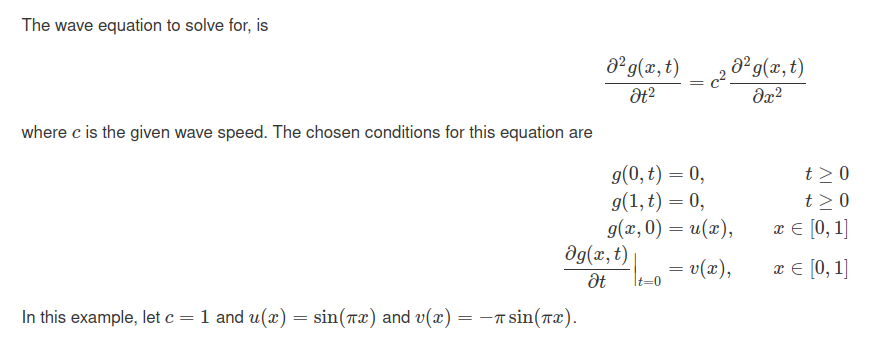

# Trial solution

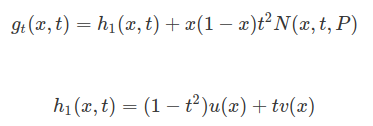

# Analytical solution

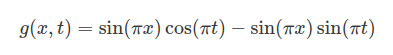

# Jacobian and Hessian

The Jacobian may be used when the program needs to find the derivative of the trial solution with respect to x and t.

This gives the necessity of computing the Jacobian matrix, as we want to evaluate the gradient with respect to x and t.

To find the second derivative with respect to x and t, the Jacobian can be found for the second time. The result is a Hessian matrix, which is the matrix containing all the possible second order mixed derivatives of g(x,t).

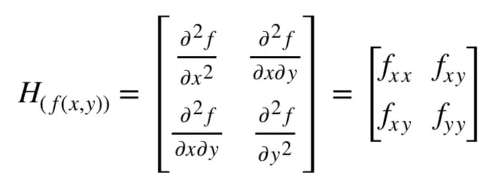

In [1]:
import autograd.numpy as np
from autograd import hessian,grad
import autograd.numpy.random as npr
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

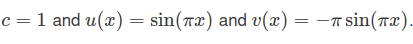

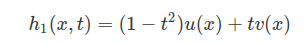

In [2]:
## Set up the trial function:
def u(x):
    return np.sin(np.pi*x)

def v(x):
    return -np.pi*np.sin(np.pi*x)

def h1(point):
    x,t = point
    return (1 - t**2)*u(x) + t*v(x)

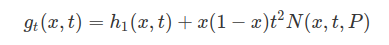

In [3]:
def g_trial(point,P):
    x,t = point
    return h1(point) + x*(1-x)*t**2*deep_neural_network(P,point)

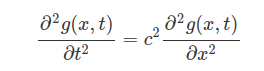

In [12]:
## Define the cost function
def cost_function(P, x, t):
    cost_sum = 0

    g_t_hessian_func = hessian(g_trial)

    for x_ in x:
        for t_ in t:
            point = np.array([x_,t_])

            g_t_hessian = g_t_hessian_func(point,P)

            g_t_d2x = g_t_hessian[0][0] #this is right-hand-side of PDE
            g_t_d2t = g_t_hessian[1][1] #this is left-hand-side of PDE

            err_sqr = ( (g_t_d2t - g_t_d2x) )**2   # cost_ij = square of (LHS-RHS)
            cost_sum += err_sqr  # sum_of_cost_in

    return cost_sum / (np.size(t) * np.size(x)) # final cost is average of the above, this is to be minimised to mind parameters


In [5]:
## The neural network
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # x is now a point and a 1D numpy array; make it a column vector
    num_coordinates = np.size(x,0)
    x = x.reshape(num_coordinates,-1)

    num_points = np.size(x,1)

    # N_hidden is the number of hidden layers
    N_hidden = len(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assume that the input layer does nothing to the input x
    x_input = x
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_points)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_points)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output[0][0]


In [6]:
## The analytical solution
def g_analytic(point):
    x,t = point
    return np.sin(np.pi*x)*np.cos(np.pi*t) - np.sin(np.pi*x)*np.sin(np.pi*t)

In [7]:
def solve_pde_deep_neural_network(x,t, num_neurons, num_iter, lmb):
    ## Set up initial weigths and biases
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 + 1 ) # 2 since we have two points, +1 to include bias
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: ',cost_function(P, x, t))

    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        print ("iteration ", i, "/", num_iter)
        cost_grad =  cost_function_grad(P, x , t)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_grad[l]


    print('Final cost: ',cost_function(P, x, t))

    return P

In [8]:
if __name__ == '__main__':
    ### Use the neural network:
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    Nx = 10; Nt = 10
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0,1,Nt)

    ## Set up the parameters for the network
    num_hidden_neurons = [50,20]
    num_iter = 60
    lmb = 0.01

    P = solve_pde_deep_neural_network(x,t, num_hidden_neurons, num_iter, lmb)

    ## Store the results
    res = np.zeros((Nx, Nt))
    res_analytical = np.zeros((Nx, Nt))
    for i,x_ in enumerate(x):
        for j, t_ in enumerate(t):
            point = np.array([x_, t_])
            res[i,j] = g_trial(point,P)

            res_analytical[i,j] = g_analytic(point)

    diff = np.abs(res - res_analytical)
    print("Max difference between analytical and solution from nn: %g"%np.max(diff))


Initial cost:  131.8509984035501
iteration  0 / 60
iteration  1 / 60
iteration  2 / 60
iteration  3 / 60
iteration  4 / 60
iteration  5 / 60
iteration  6 / 60
iteration  7 / 60
iteration  8 / 60
iteration  9 / 60
iteration  10 / 60
iteration  11 / 60
iteration  12 / 60
iteration  13 / 60
iteration  14 / 60
iteration  15 / 60
iteration  16 / 60
iteration  17 / 60
iteration  18 / 60
iteration  19 / 60
iteration  20 / 60
iteration  21 / 60
iteration  22 / 60
iteration  23 / 60
iteration  24 / 60
iteration  25 / 60
iteration  26 / 60
iteration  27 / 60
iteration  28 / 60
iteration  29 / 60
iteration  30 / 60
iteration  31 / 60
iteration  32 / 60
iteration  33 / 60
iteration  34 / 60
iteration  35 / 60
iteration  36 / 60
iteration  37 / 60
iteration  38 / 60
iteration  39 / 60
iteration  40 / 60
iteration  41 / 60
iteration  42 / 60
iteration  43 / 60
iteration  44 / 60
iteration  45 / 60
iteration  46 / 60
iteration  47 / 60
iteration  48 / 60
iteration  49 / 60
iteration  50 / 60
iteratio

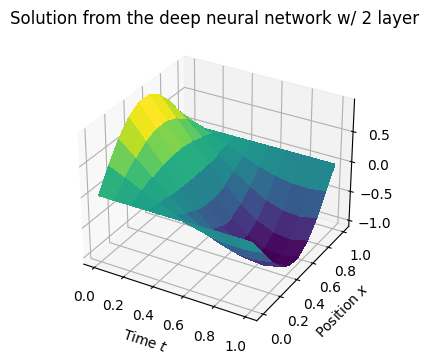

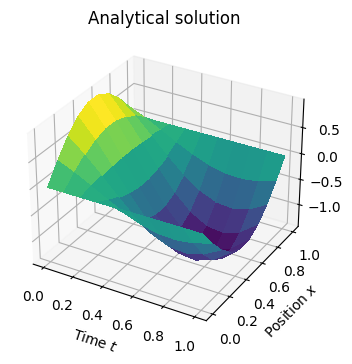

In [9]:
    ## Plot the solutions in two dimensions, that being in position and time

    T,X = np.meshgrid(t,x)

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Solution from the deep neural network w/ %d layer'%len(num_hidden_neurons))
    s = ax.plot_surface(T,X,res,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');


    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Analytical solution')
    s = ax.plot_surface(T,X,res_analytical,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

In [10]:
    ## Take some slices of the 3D plots just to see the solutions at particular times
    indx1 = 0
    indx2 = int(Nt/2)
    indx3 = Nt-1

    t1 = t[indx1]
    t2 = t[indx2]
    t3 = t[indx3]

    # Slice the results from the DNN
    res1 = res[:,indx1]
    res2 = res[:,indx2]
    res3 = res[:,indx3]

    # Slice the analytical results
    res_analytical1 = res_analytical[:,indx1]
    res_analytical2 = res_analytical[:,indx2]
    res_analytical3 = res_analytical[:,indx3]

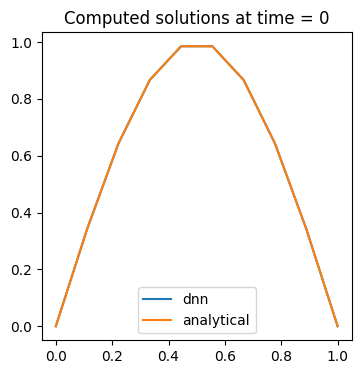

In [13]:
    # Plot the slices
    plt.figure(figsize=(4,4))
    plt.title("Computed solutions at time = %g"%t1)
    plt.plot(x, res1)
    plt.plot(x,res_analytical1)
    plt.legend(['dnn','analytical'])


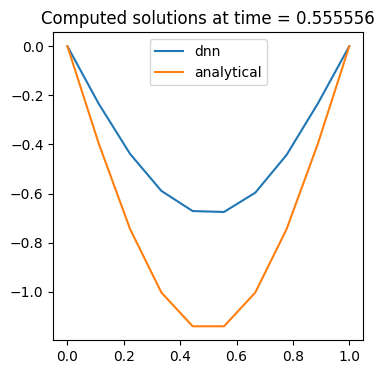

In [15]:

    plt.figure(figsize=(4,4))
    plt.title("Computed solutions at time = %g"%t2)
    plt.plot(x, res2)
    plt.plot(x,res_analytical2)
    plt.legend(['dnn','analytical'])



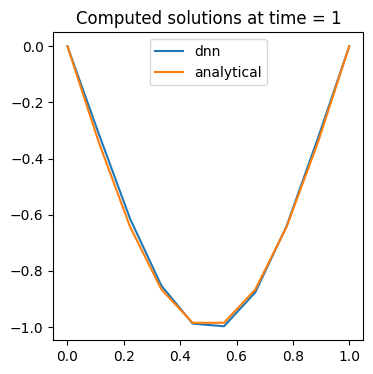

In [16]:
    plt.figure(figsize=(4,4))
    plt.title("Computed solutions at time = %g"%t3)
    plt.plot(x, res3)
    plt.plot(x,res_analytical3)
    plt.legend(['dnn','analytical'])
